# Assignment 4

### Samuel Sheehy (Student ID 18143565)

### Techniques of High Performance Computing (PHAS0102)

### MSc Scientific Computing, University College London, 2019-2020

**This Jupyter Notebook is submitted as completion of the 4th Assignment for the UCL course cited above.**

## Setup

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from math import ceil
import logging

from scipy.sparse.linalg import LinearOperator, cg, spilu

import pyopencl as cl


TRUE_RESULT = 0.424011387033 # The expected answer to 12 significant figures


logger = logging.getLogger('heat')
logger.setLevel(logging.DEBUG)
if not logger.handlers:
    hdlr = logging.FileHandler('heat.log', mode='w', encoding='latin-1')
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
        

import time
class Timer:
    """
    A simple timer class to measure the execution time
    of a function (seconds) in a ```with``` block.
    Taken from module lecture notes.
    """
    def __enter__(self):
        """
        Measure time at start.
        """
        self.start = time.time()
        return self

    def __exit__(self, *args):
        """
        Measure time at end and take difference
        from start.
        """
        self.end = time.time()
        self.interval = self.end - self.start
        

def bytesize(N, dtype_str):
    """
    Returns the number of bytes that an array of element
    size N occupies
    """
    return np.dtype(dtype_str).itemsize*N


def log(f):
    x = None
    try: 
        logger.info(35*'-' + 'New Run' + 35*'-')
        with Timer() as t:
            ### Exec Code
            x = f()
            ###
        logger.info(f'Total Run Time: {t.interval:.3E} s')
    except KeyboardInterrupt:
        logger.error('Keyboard Interrupt')
#         logger.emit()
    if x:
        return x

## Introduction of Problem
* Intro to the problem we are solving and the Heat Equation 


## Mathematical Derivation of Numerical Scheme

* Finite difference method:

CN finite difference in spacial dimension.
$$
u_h(t, x, y) = u_h(t - \tau, x, y) -  \frac{\tau}{h^2} \left[ 4 u_h(t - \tau, x, y)
- u_h(t - \tau, x - h, y) - u_h(t - \tau, x + h, y) - u_h(t - \tau, x, y - h) - u_h(t - \tau, x, y + h) \right] + again
$$

* How I formulate this as a matrix


## My Method
* From mathematical formulation, components of calculation are: 
    - Construction of matrices A(t) and A(t+1)
    - Calculate $u_* = A(t)u(t) + [bc]$ - maybe use OpenCL kernel?
    - Solve for $u(t+1)$: $A(t+1)u(t+1) = u_* $ (CG method -  preconditioner through LU decomposition)
    - Use secant method to find answer

## Analysis
* Show influence of size of timestep and spacestep in finding correct answer
* How time completion of each section increases with system size
* Overall convergence of final solution

In [2]:
### Helper Methods ###
def is_bc(i, j, M):
    """
    Check if the given coordinates correspond to a boundary.
    """
    if i == 0 or i == M - 1:
        return True
    elif j == 0 or j == M - 1:
        return True
    else:
        return False

    
def show(b, R, C):
    """
    Display an image of the solution on the square.
    
    TODO: generalise to any BC function
    """
    # Put flattened vector back into square
#     M = int(len(b)**0.5)
    p = b.reshape(R, C)
    
#     # Reinclude the original boundary conditions
#     p = np.pad(p, 1)
#     p[:, 0] = 0  # left bc
#     p[:, -1] = 0 # right bc
#     p[-1, :] = 0 # top bc
#     p[0, :] = 5  # bottom bc

    # Display the solution
    plt.imshow(p, origin='lower')
    plt.colorbar()
    plt.show()

In [3]:
# At: a, a, 1 - 4*a, a, a

class FivePointStencil(LinearOperator):
    """
    Apply a 5-point stencil operator to a row-wise flattened
    lattice.
    """
    _openCL_code = """
    __kernel void matvec(
            __global double *vector,
            __global double *result,
            double alpha,
            double beta,
            double gamma,
            int XR,
            int XC
        )
        {        
        // Get Global Identifiers i.e. the row or col index
        int row_index = get_global_id(0); // offset by one to only look
        int col_index = get_global_id(1);    // at inner lattice
        
        
        // Determine boolean operators.
        // These decide if a particular term is active or not.
        int b1 = (int) (row_index + 1 != 1);   //bottom
        int b2 = (int) (row_index + 1 != XR); //top
        int b3 = (int) (col_index + 1 != 1);   //left
        int b4 = (int) (col_index + 1 != XC); //right
        
        int loc = row_index*XC + col_index;
        
        // Do stuff
        double product = alpha*vector[loc]              // center
                         + b1*beta*vector[b1*(loc-XC)] // bottom
                         + b2*beta*vector[b2*(loc+XC)] // top
                         + b3*beta*vector[b3*(loc-1)]   // left
                         + b4*beta*vector[b4*(loc+1)];  // right
    
        // Output answer
        
        result[loc] = product;
        
        }
    """
    def __init__(self, alpha, beta, XR, XC):
        """
        Initialise the OpenCL kernel with the given parameters.
        
        Arguments
        ---------
        alpha:
        
        beta:
        
        bounds (top/bottom):
        
        M:
        """
        self.Mop = XR*XC
        self.shape = (self.Mop, self.Mop)
#         self.M = M
        self.XR = XR
        self.XC = XC
        self.dtype = np.dtype(np.float64)
        self.explicit = False
        self._vector_buffer = None
        self._result_buffer = None
        self.mapped_vector_buffer = None
        self.mapped_result_buffer = None
        self.alpha = alpha
        self.beta = beta
        self.c = 0
        self.offset = 0
        # Define kernel
        self._kernel = self._build_kernel()
    
    def _build_kernel(self):
        """
        Construct the kernel.
        """
        # Initialise the OpenCL environment
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags
    
        # Create the buffer to hold the vector data
        self._vector_buffer = cl.Buffer(self.ctx, self.mf.ALLOC_HOST_PTR, bytesize(self.Mop, 'double'))

        # Create buffer to hold the result
        self._result_buffer = cl.Buffer(self.ctx, self.mf.ALLOC_HOST_PTR, size=bytesize(self.Mop, 'double'))
                                
        # Build the Kernel
        prg = cl.Program(self.ctx, FivePointStencil._openCL_code)
        prg.build()
        matvec_kernel = prg.matvec
        
        # Map Buffers
        self.mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
            self.queue, self._vector_buffer, cl.map_flags.WRITE, self.offset, self.Mop, np.double
        )
        linking_event.wait()

        self.mapped_result_buffer, linking_event = cl.enqueue_map_buffer(
            self.queue, self._result_buffer, cl.map_flags.READ,
            self.offset, self.Mop, np.double
        )
        linking_event.wait()
        
        return matvec_kernel
    
    def _exec_kernel(self, x, alpha, beta, c):        
        # Rewrite vector buffer

        self.mapped_vector_buffer[:] = x    

        # Run the kernel
        self._kernel(
            # Workspace parameters
            self.queue, (self.XR, self.XC), None, # offset Ms to only look at inner lattice
            # Buffers
            self._vector_buffer, self._result_buffer,
            # Other parameters passed to kernel
            np.float64(alpha), np.float64(beta), np.float64(c), np.int32(self.XR), np.int32(self.XC)
        )

        fetched_result = self.mapped_result_buffer[:]
        self.queue.finish()
        return fetched_result

    def _matvec(self, x):
        """
        Apply the initialised operator to the given vector.
        """
        return self._exec_kernel(x, self.alpha, self.beta, self.c) 

# _M = 5
# _N = 4
# _Mop = _M*_N
# LOP = FivePointStencil(4, -1, _M, _N)
# _Mop = _M*_N

# %timeit LOP @ np.ones(_Mop)

In [4]:
# with mapping in setup: 84.4 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

In [56]:
# Crank-Nicholson Method
def get_system_size(h0):
    # Double the size of M since its dimensions corners
    # oppose themselves around the center.
    M = ceil(2/h0)
    
    # Ensure that M is odd so that there is a unique value
    # at its center.
    if M % 2 == 0:
        M += 1
    
    return M

def calibrate_h(M):
    """
    Redefine h to fit in system size
    """
    return 2/M


def build_preconditioner(XR, XC, tau, h, dt, ff):
    alpha = calc_alpha(tau, h)
    Mop = XR*XC
    At2 = build_sparse_matrix(XR, XC, 1 + 4*alpha, -alpha)
    P = create_preconditioner(At2, dt, ff)
    return P
    

def calc_alpha(tau, h):
    # Set stepping term
    alpha = tau/h**2/2
    return alpha

        
def build_sparse_matrix(XR, XC, alpha_center, alpha_edge):
    """
    Build a matrix which applies the Crank-Nicholsong finite difference
    scheme to solve the problem.
    
    TODO: Generalise region limits and boundary conditions
    """
    data = []
    rows = []
    cols = []    
        
    # Determine the length of the operator
    M_op = XR*XC # Removes edges
    
    def add(datasource, val, row, colshift):
        """
        Add coefficient to operator.
        """
        datasource.append(val)
        rows.append(row)
        if row+colshift < 0:
            msg = f'Negative col index {row}: {colshift}'
            logger.error(msg)
            raise Exception(msg)
        cols.append(row+colshift)
    
    k = 0
    for row_idx in range(0, XR):
        for col_idx in range(0, XC):            
#             # Matrix
#             if is_bc(row_idx, col_idx, M):
#                 msg = 'Adding a bc to matrix - not correct'
#                 logger.error(msg)
#                 raise Exception(msg)
            # center
            add(data, alpha_center, k, 0)
            
            # left
            if col_idx >= 1:
                add(data, alpha_edge, k, -1)
            
            # right
            if col_idx < XC - 1:
                add(data, alpha_edge, k, 1)
            
            # top
            if row_idx < XR - 1:
                add(data, alpha_edge, k, XC)
            
            # bottom
            if row_idx >= 1:
                add(data, alpha_edge, k, -XC)
            
            k += 1
            
    # Check for negative column indexes
    if any([x<0 for x in cols]):
        msg = f'Negative column index {i}'
        logger.error(msg)
        raise Exception(msg)

    A = coo_matrix((data, (rows, cols))).tocsc()#.astype(np.float32)
    
    # Ensure matrix is square
    if A.shape[0] != A.shape[1]:
        msg = f'Matrix is not square: {A.shape}'
        logger.error(msg)
        raise Exception(msg)
    
    # Ensure it's the expected size
    if A.shape[0] != M_op:
        msg = f'Matrix wrong size:{A.shape[0]}'
        logger.error(msg)
        raise Exception(msg)

    return A


def build_operators(alpha, XR, XC):
#     At  = build_sparse_matrix(XR, XC, 1 - 4*alpha, alpha)
#     At2 = build_sparse_matrix(XR, XC, 1 + 4*alpha, -alpha)
    At2 = FivePointStencil(1 + 4*alpha, -alpha, XR, XC)
    At  = FivePointStencil(1 - 4*alpha,  alpha, XR, XC)
    return At, At2


def define_boundary_vector(bounds_top, bounds_bottom, alpha, XR, XC):
    """
    TODO
    """
    Mop = XR*XC
    b = np.zeros(Mop)
    k = 0
    for row_idx in range(XR):
        for col_idx in range(XC):
            # Consider Boundary influences
            # TOP
            if row_idx == XR-1:
                b[k] += bounds_top[col_idx]
            
            # BOTTOM
            if row_idx == 0:
                b[k] += bounds_bottom[col_idx]
            
#             # LEFT
#             if is_bc(row_idx, col_idx + 1, M):
#                 b[k] += 0
            
#             # RIGHT
#             if is_bc(row_idx, col_idx - 1, M):
#                 b[k] += 0

            k += 1
    
    return b*alpha


def setup_system(XR, XC, h, tau, dt, ff):
    """
    Create the matrices and vectors for the system
    """
    # Get operators and boundary condition operator
    # this builds the matrix at every evaluation
    # Determine number of timesteps
    logger.info(f'tau:{tau:.4E} - h:{h:.4E}')
    logger.info(f'Drop factor: {dt} - Fill Factor: {ff}')
    with Timer() as t:
        At, At2, At2LOP, alpha = build_CN_system(M, tau, h)
    logger.info(f'Built system in {t.interval:.3E} s')
    logger.info(f'Matrix Size: {At.shape[0]}')
    
    with Timer() as t:
        P = create_preconditioner(At2, dt, ff)
    logger.info(f'Built preconditioner in {t.interval:.3E} s')
    
    return At, At2LOP, P, alpha

def advance_segmented():
    Nprog = 1
    for i, N in enumerate(Nlist):
        # setup
        XR, XC, At, At2, P = params_lookup[N]
        xbounds_bottom = U[(Nprog-1)*XC:(Nprog)*XC]
        xbounds_top = U[(Nprog+N)*XC:(Nprog+N+1)*XC]  
        bounds = define_boundary_vector(xbounds_top, xbounds_bottom, alpha, XR, XC)
        loc1 = (Nprog)*XC
        loc2 = (Nprog+N)*XC
        subU = U[loc1:loc2]
        # calc
        U[loc1:loc2], dT1, dT2 = advance_in_time(subU, At, At2, P, bounds)
        # prep for next
        Nprog += N
        prevN = N


def advance_in_time(u_old, At, At2, P, bounds):
    """
    Advance one timestep
    """
    with Timer() as t1:
        u_temp = (At @ u_old + 2*bounds)
        
    with Timer() as t2:
        u_new, _ = faster_inversion_solve(At2, u_temp, P=P)
    
    return u_new, t1.interval, t2.interval


def advance_segmented(u_old, Nlist, params_lookup, alpha):
    prevN = 0
    Nprog = 1
    U = u_old
    for i, N in enumerate(Nlist):
        # setup
        XR, XC, At, At2, P = params_lookup[N]
#         print(U.shape, (Nprog-1)*XC, (Nprog)*XC)
        xbounds_bottom = U[(Nprog-1)*XC:(Nprog)*XC]
        xbounds_top = U[(Nprog+N)*XC:(Nprog+N+1)*XC]  
        bounds = define_boundary_vector(xbounds_top, xbounds_bottom, alpha, XR, XC)
        loc1 = (Nprog)*XC
        loc2 = (Nprog+N)*XC
        subU = U[loc1:loc2]
        # calc
        U[loc1:loc2], dT1, dT2 = advance_in_time(subU, At, At2, P, bounds)
        # prep for next
        Nprog += N
        prevN = N
    return U


def build_segmented(M, tau, h, n_segments, dt, ff):
    Nsize = (M-2)//n_segments
    Nlist = [Nsize if i != n_segments - 1 else Nsize+((M-2)%Nsize) for i in range(n_segments)]
    Nuniq = list(set(Nlist))        # get unique entries
    print(M, Nlist, sum(Nlist), Nuniq)
    params_lookup = {}
    alpha = calc_alpha(tau, h)
    print('alpha:', alpha)
    bounds_top = np.ones(M-2)*0
    bounds_bottom = np.ones(M-2)*5
    OR = M
    OC = M - 2
    print('System Size:', OR*OC)
    for N in Nuniq:
        XR = N
        XC = OC
        print('Subsystem Size:', N, XR*XC)
        At, At2 = build_operators(alpha, XR, XC)
        P = build_preconditioner(XR, XC, tau, h, dt, ff)
        params_lookup[N] = (XR, XC, At, At2, P)
    return Nlist, params_lookup, bounds_top, bounds_bottom, alpha

    

def temp_at_time_segmented(T_target0, T_target1, At, At2, P, bounds, tau, Nlist):
    """
    Advance one timestep by diving the space into chunks and solving
    for each chunk
    """
    Telapsed = 0
    U = np.ones(OR*OC)*0
    U[0:OC] = bounds_bottom[:]
    U[OC*(OR-1):OR*OC] = bounds_top[:]    
    k = 0
    while Telapsed < Ttarget:
        U = advance_segmented(u_old, Nlist, params_lookup, alpha)
        Telapsed += tau
        k += 1
    return U, OR, OC


# def temp_at_time(T_target0, T_target1, At, At2, P, bounds, tau):
def temp_at_time(Uinit, T_target0, T_target1, Nlist, params_lookup, tau, alpha, OR, OC):
    """
    Calculates the temperature at the central point at a given
    time t, according to a spacial step h and a time step tau.
    """    
    T1 = 0
    T2 = 0
    
    # Initialise the estimate for the lattice solution
    Uf = [Uinit, Uinit]
    u = Uf[0]
    
    # Determine the smaller target and get there indexes
    
    T_target = [T_target0, T_target1]
    rank_min = min(T_target) != T_target0
    rank_max = not rank_min
    
    logger.debug(f'T_target values are {T_target[0]} and {T_target[1]}')
    logger.debug(f'The smallest is at index {int(rank_min)}, the largest at {int(rank_max)}')
                 
    
    # Effectuate iteration until time reached
    k = 0
    while k*tau < T_target[rank_min]:
#         u, dT1, dT2 = advance_in_time(u, At, At2, P, bounds, tau)
        u = advance_segmented(u, Nlist, params_lookup, alpha)
#         T1 += dT1
#         T2 += dT2
        k += 1
    Uf[rank_min] = u
    
    while k*tau < T_target[rank_max]:
#         u, dT1, dT2 = advance_in_time(u, At, At2, P, bounds, tau)
        u = advance_segmented(u, Nlist, params_lookup, alpha)
#         T1 += dT1
#         T2 += dT2
        k += 1
    Uf[rank_max] = u

    logger.info(f'RHS Op: {T1:.2E} s - Inversion: {T2:.2E}')
    
    return Uf[0], Uf[1]


def secant_method(f, rhs, x0, x1, tol, maxiter=1000):
    """
    Using the secant method, solve the system f(x) = rhs.
    """
    # Initiate parameters
    def fzero(x0, x1): 
        f0, f1 = f(x0, x1)
        return f0 - rhs, f1 - rhs
    x_1 = x1
    x_0 = x0
    k = 0
    # Iterate
    while abs(x_1 - x_0) > tol and k < maxiter:
        f0, f1 = fzero(x_0, x_1)
        x_new = x_1 - f1*(x_1 - x_0)/(f1 - f0)
        x_0 = x_1
        x_1 = x_new
        k += 1
        logger.info(f'New estimate for solution: {x_new}')
    
    if k >= maxiter:
        logger.warning(f'Solver exited before finding a solution. k is {k}')
    else:
        logger.info(f'Secant method converged in {k} iterations')
    return x_new


def get_center_value(u):
    """
    Return the value at the center of the lattice
    """
    return u[len(u)//2]


def center_temp_at_time(t0, t1, At, At2, P, bounds, tau):
    """
    Determine the temparature at the center of the lattice
    at the time t for th given step sizes h and tau.
    """
    u0, u1 = temp_at_time(t0, t1, At, At2, P, bounds, tau)
    center0 = get_center_value(u0)
    center1 = get_center_value(u1)
    return center0, center1


def segmented_solve(T, h0, _tau, tol, dt, ff, x0, x1, xmax):
    """
    Solve the problem in segments.
    """
    logger.info(f'Starting segmented solve with ({x0}, {x1})')
    # Determine size of solvers
    M = get_system_size(h0)
    h = calibrate_h(M)
    At, At2, P, alpha = setup_system(M, h, tau, dt, ff)
    
    
def main_solve(T, h0, _tau, tol, dt, ff, x0, x1, xmax):
    """
    Determine the solution of the initial problem.
    """
    logger.info(f'Starting solve with x0: {x0} and x1:{x1}')
    
    tau = calibrate_tau(xmax, _tau)
    M = get_system_size(h0)
    h = calibrate_h(M)
    At, At2, P, bounds = setup_system(M, h, tau, dt, ff, bounds_top, bounds_bottom)
    f = lambda t0, t1: center_temp_at_time(t0, t1, At, At2, P, bounds, tau)
    with Timer() as t:
        center_T = secant_method(f, T, x0, x1, tol)
    logger.info(f'Secant method complete in {t.interval:.2E} s')
    logger.info(f'Solution is {center_T}')
    return center_T


def calibrate_tau(T_final, tau):
    """
    Ensure that the timesteps correspond to the final
    time and get the number of timesteps.
    """
    logger.info(f'Time T is {T_final:.6f}')
    nt = ceil(T_final/tau)
    calibrated_tau = T_final/nt
    return calibrated_tau

In [48]:
# Speed Up 1: Inversion of A with a preconditioner
def create_preconditioner(A, dt, ff):
    """
    Using SPILU and a specified drop tolerance, create a preconditioner
    for A.
    """
    ilu = spilu(A, drop_tol=dt, fill_factor=ff)
    Mx = lambda x: ilu.solve(x.astype(np.float32))
    N = A.shape[0]
    P = LinearOperator((N, N), Mx)
    return P


def heartbeat(u):
    pass


def faster_inversion_solve(A, b, P=None, maxiter=1000):
    """
    Solve the sysem Ax = b for x.
    
    TODO: Experiment with drop tolerance
    """
    history = []
    def error_calc(u):
        """
        Local function to exctract error from plot.
        """
        error = np.linalg.norm(A@u - b)
        history.append(error)
    x, info = cg(A, b, callback=error_calc, M=P, maxiter=maxiter)
    # Check convergence status of solution
    if info > 0:
        pass
#         print(f'Did not converge at i={info}! iter:', info)
    if info < 0:
        logger.error(f'There was an error in cg at i={info}')
        raise Exception('CG failed')
    return x, history

In [29]:
def test():
    logger.info('Temp at T Test')
    T = TRUE_RESULT
    tau = 1e-2
    h = 1e-2
    dt = 1e-5
    ff = 20
    M = get_system_size(h)
    tau = calibrate_tau(T, tau)
    # Begin Test
    bounds_top = np.ones(M-2)*0
    bounds_bottom = np.ones(M-2)*5
    At, At2, P, alpha = setup_system(M, M, h, tau, dt, ff)
    bounds = define_boundary_vector(bounds_top, bounds_bottom, alpha, XR, XC)
    _, x = center_temp_at_time(0, T, At, At2, P, bounds, tau)
    logger.info(f'Temperature at {T} s is {x}')
    return x

# try:
#     log(lambda: test())
# except Exception as e:
#     logger.error('%s'%e)
#     raise e

201 [49, 49, 49, 52] 199 [49, 52]
alpha: 505.01250000000005
System Size: 39999
Subsystem Size: 49 9751
Subsystem Size: 52 10348
MainRun


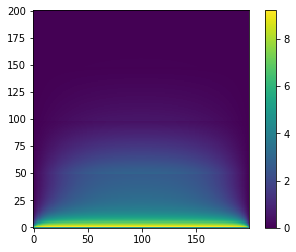

201 199
0.5319534916989618


In [53]:
def test():
#     logger.info('Temp at T Segmented')
    Ttarget = TRUE_RESULT
    tau = 1e-1
    h0 = 1e-2
    dt = 1e-5
    ff = 20
    n_segments = 4
    M = get_system_size(h0)
    h = calibrate_h(M)
    Nsize = (M-2)//n_segments
    Nlist = [Nsize if i != n_segments - 1 else Nsize+((M-2)%Nsize) for i in range(n_segments)]
    Nuniq = list(set(Nlist))        # get unique entries
    print(M, Nlist, sum(Nlist), Nuniq)
    params_lookup = {}
    alpha = calc_alpha(tau, h)
    print('alpha:', alpha)
    bounds_top = np.ones(M-2)*0
    bounds_bottom = np.ones(M-2)*5
    OR = M
    OC = M - 2
    print('System Size:', OR*OC)
    for N in Nuniq:
        XR = N
        XC = OC
        print('Subsystem Size:', N, XR*XC)
        At, At2 = build_operators(alpha, XR, XC)
        P = build_preconditioner(XR, XC, tau, h, dt, ff)
        params_lookup[N] = (XR, XC, At, At2, P)
    
    print('MainRun')
    prevN = 0
    Telapsed = 0
    U = np.ones(OR*OC)*0
    U[0:OC] = bounds_bottom[:]
    U[OC*(OR-1):OR*OC] = bounds_top[:]    
    k = 0
    while Telapsed < Ttarget:
        Nprog = 1
        for i, N in enumerate(Nlist):
            # setup
            XR, XC, At, At2, P = params_lookup[N]
            xbounds_bottom = U[(Nprog-1)*XC:(Nprog)*XC]
            xbounds_top = U[(Nprog+N)*XC:(Nprog+N+1)*XC]  
            bounds = define_boundary_vector(xbounds_top, xbounds_bottom, alpha, XR, XC)
            loc1 = (Nprog)*XC
            loc2 = (Nprog+N)*XC
            subU = U[loc1:loc2]
            # calc
            U[loc1:loc2], dT1, dT2 = advance_in_time(subU, At, At2, P, bounds)
            # prep for next
            Nprog += N
            prevN = N
        Telapsed += tau
        k += 1
    
    return U, OR, OC
        
        
u, XR, XC = test()
show(u, XR, XC)
print(XR, XC)
print(get_center_value(u))

201 [66, 66, 67] 199 [66, 67]
alpha: 50.50125
System Size: 39999
Subsystem Size: 66 13134
Subsystem Size: 67 13333
MainRun
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,) 13134 13333
(39999,) 26268 26467
(39999,) 0 199
(39999,

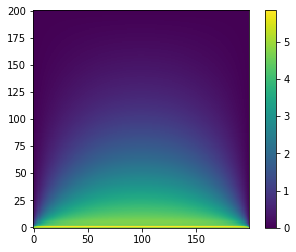

201 199
1.0222529615575222


In [58]:
def test():
#     logger.info('Temp at T Segmented')
    Ttarget = TRUE_RESULT
    tau = 1e-2
    h0 = 1e-2
    dt = 1e-5
    ff = 20
    n_segments = 1
    M = get_system_size(h0)
    h = calibrate_h(M)
    
    Nlist, params_lookup, bounds_top, bounds_bottom, alpha = build_segmented(M, tau, h, n_segments, dt, ff)
    
    OR = M
    OC = M - 2
    
    print('MainRun')
    Uinit = np.ones(OR*OC)*0
    Uinit[0:OC] = bounds_bottom[:]
    Uinit[OC*(OR-1):OR*OC] = bounds_top[:]    
    k = 0
    U0, U1 = temp_at_time(Uinit, 0, Ttarget, Nlist, params_lookup, tau, alpha, OR, OC)
    
    return U1, OR, OC
        
        
u, XR, XC = test()
show(u, XR, XC)
print(XR, XC)
print(get_center_value(u))

In [ ]:
# Solve
def test():
    # Setup
    tau = 1e-2
    h = 1e-2
    dt = 1e-5
    ff = 20
    tol = 1e-3
    x0 = 0.4
    x1 = 0.42
    xmax = 0.5
    T = 1
    logger.info('Begin Time to 1 Test')
    estimate = main_solve(T, h, tau, tol, dt, ff, x0, x1, xmax)
    logger.info(f'Time to reach {T} is {estimate} s, tol={tol:.2E}' )
    return estimate

# try:
#     estimate = log(lambda: test())
# except Exception as e:
#     logger.error('%s'%e)
#     raise e

# Error
print(f'{estimate}\nError from correct solution is {abs(estimate - TRUE_RESULT): .4E}')

In [ ]:
# U = temp_at_time(TRUE_RESULT, 1/64, 1e-3)
# show(U)

In [ ]:
# center_temp_at_time(TRUE_RESULT, 1e-2, 1e-2)

# Optimisation

## Inversion 

#### Detemrmining drop tolerance and fill factor for SPILU

In [ ]:
def study_ilu_convergence(h, tau, drop_tol_list, fill_fact_list):
    """
    For a system of size h, apply Scipy's ILU rountine
    for various drop factors and compare the rates of convergence for each
    run.
    """
    At, At2, At2LOP, bounds = build_CN_system(tau, h)
    b = np.ones(At2.shape[0])
    convergences = np.zeros((len(drop_tol_list), len(fill_fact_list)))
    for i, dt in enumerate(drop_tol_list):
        for j, ff in enumerate(fill_fact_list):
            P = create_preconditioner(At2, dt, ff)
            sol, history = faster_inversion_solve(At2, b, P, maxiter=200)
            convergences[i, j] = len(history)
    
    convergences[convergences==200]=np.nan
    plt.imshow(convergences)

    plt.xlabel('fill factor')
    plt.ylabel('drop tolerance')
    plt.title('Comparison of Convergence for Various Drop Factors and Fill Factors')
#     plt.legend(loc='upper right')
    plt.colorbar()
    fig = plt.gcf()
    fig.dpi = 100
    plt.show()

droptols = 10**np.linspace(-4, -5, 3)
fill_factors = np.linspace(15, 20, 3)
print(['%4E'%dt for dt in droptols])
print([ff for ff in fill_factors])
# study_ilu_convergence(5e-3, 5e-3, droptols, fill_factors)